# ELEC 576 / COMP 576 - Fall 2018 Assignment 2

## 1 Visualizing a CNN with CIFAR10

### a) CIFAR10 Dataset

Load CIFAR10 Dataset:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(10000, 28, 28, 1) (10000, 10) (1000, 28, 28, 1) (1000, 10)


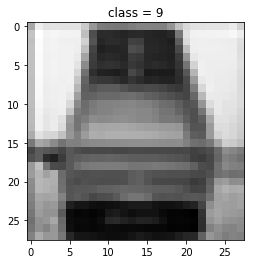

In [6]:
%load_ext autoreload
%autoreload 2

from trainCifarStarterCode import *
import numpy as np
import imageio
from IPython.display import clear_output

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

ntrain = 1000 # per class
ntest = 100 # per class
nclass = 10 # number of classes
imsize = 28
nchannels = 1

Train = np.zeros((ntrain*nclass, imsize, imsize, nchannels))
Test = np.zeros((ntest*nclass, imsize, imsize, nchannels))
LTrain = np.zeros((ntrain*nclass, nclass))
LTest = np.zeros((ntest*nclass, nclass))

itrain = -1
itest = -1
for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = './CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        im = imageio.imread(path); # 28 by 28
        im = im.astype(float)/255
        itrain += 1
        Train[itrain,:,:,0] = im
        LTrain[itrain,iclass] = 1 # 1-hot lable
    for isample in range(0, ntest):
        path = './CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = imageio.imread(path); # 28 by 28
        im = im.astype(float)/255
        itest += 1
        Test[itest,:,:,0] = im
        LTest[itest,iclass] = 1 # 1-hot lable

print(Train.shape, LTrain.shape, Test.shape, LTest.shape)

# display an image
plt.imshow(Train[-1,:,:,0], cmap='gray')
plt.title('class = %d'%np.argmax(LTrain[-1]))
plt.show()

### b) Train LeNet5 on CIFAR10

Model architecture:

    • Convolutional layer with kernel 5 x 5 and 32 filter maps followed by ReLU
    • Max Pooling layer subsampling 2
    • Convolutional layer with kernel 5 x 5 and 64 filter maps followed by ReLU
    • Max Pooling layer subsampling by 2
    • Fully Connected layer that has input 7*7*64 and output 1024
    • Fully Connected layer that has input 1024 and output 10 (for the classes)
    • Softmax layer (Softmax Regression + Softmax Nonlinearity)
    
Figure 1 visualizes this architecture.

<img src="https://github.com/bl166/LearningDeepLearning/blob/master/figures/Picture1.png?raw=true" alt="Drawing" style="width: 200px;"/>


<center>Figure 1 LeNet5 Architecture</center>

In [3]:
class LeNet5(object):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        # --------------------------------------------------
        # model
        #create your model

        # first convolutional layer
        self.h_pool1 = conv_layer(self.X, [5, 5, 1, 32], 'conv1', tf.nn.relu)

        # second convolutional layer
        self.h_pool2 = conv_layer(self.h_pool1, [5, 5, 32, 64], 'conv2', tf.nn.relu)

        # densely connected layer
        self.h_fc1 = fc_layer(self.h_pool2,[7 * 7 * 64, 1024], 'fc1', tf.nn.relu)

        # dropout
        self.keep_prob = tf.placeholder(tf.float32)
        self.h_fc1_drop = dropout(self.h_fc1, self.keep_prob, 'drop')

        # softmax
        self.h = fc_layer(self.h_fc1_drop, [1024, 10], 'fc2', None)#tf.nn.softmax)
        
        self.y_ = tf.nn.softmax(self.h)
        
        
    def loss(self, learning_rate):
        # --------------------------------------------------
        # loss
        #set up the loss, optimization, evaluation, and accuracy

#         self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.y * tf.log(self.y_), reduction_indices=[1]), name="loss_function")
        self.cross_entropy = tf.losses.softmax_cross_entropy(self.y, self.h)
#         self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cross_entropy)
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.cross_entropy)
        correct_prediction = tf.cast(tf.equal(tf.argmax(self.y_,1), tf.argmax(self.y,1)), tf.float32, name="correct_prediction")
        self.accuracy = tf.reduce_mean(correct_prediction, name="accuracy")
        
        tf.summary.scalar("loss", self.cross_entropy)
        tf.summary.scalar("accuracy", self.accuracy)
 
        self.summary_op = tf.summary.merge_all()
        
        # Add the variable initializer Op.
        self.init = tf.global_variables_initializer()

        # Create a saver for writing training checkpoints.
        self.saver = tf.train.Saver()
        
        # Create session to reuse
        self.sess = tf.Session()


        
    def train(self, X, y, batchsize, nepoch, save=True):
        
        self.sess.run(self.init)
        train_writer = tf.summary.FileWriter(result_dir+'/train', self.sess.graph)
        test_writer = tf.summary.FileWriter(result_dir+'/test', self.sess.graph)

        nsamples = y.shape[0]
        perm = np.arange(nsamples)
        steps = np.floor(nsamples/batchsize).astype(int)
        global_step = 0
        best_acc = 0
        checkpoint_file = result_dir+'/checkpoint'

        for i in range(nepoch): # try a small iteration size once it works then continue
            # shuffle for this epoch 
            np.random.shuffle(perm)
            
            for n in range(steps):
                batch_ind = perm[(n*batchsize):((n+1)*batchsize)]

                summary_str, _ = self.sess.run([self.summary_op, self.optimizer], 
                        feed_dict={self.X: X[batch_ind], self.y: y[batch_ind], self.keep_prob: .5})
                global_step += 1

                train_writer.add_summary(summary_str, i)
                train_writer.flush()

                if global_step % 100 == 0:  # Record summaries and test-set accuracy
                    summary_str, acc = self.sess.run([self.summary_op, self.accuracy], 
                            feed_dict={self.X: Test, self.y: LTest, self.keep_prob: 1})
                    test_writer.add_summary(summary_str, i)
                    test_writer.flush()

                    print("step %d (ep %d), test accuracy %g"%(global_step, i, acc))
                    
                    if acc > best_acc:
                        best_acc = acc
                        if save:
                            self.saver.save(self.sess, checkpoint_file, global_step=global_step)
                            print("saving...")
                    
                    
    def test(self, X, y):
        y_prob, acc = self.sess.run([self.y_, self.accuracy], 
                feed_dict={self.X: X, self.y: y, self.keep_prob: 1})

        print("test accuracy %g"%(acc))
        return y_prob, acc

    
    def restore(self, result_dir):
        ckpt = tf.train.get_checkpoint_state(result_dir)
        if ckpt and ckpt.model_checkpoint_path:
            self.saver.restore(self.sess, ckpt.model_checkpoint_path)
        else:
            raise ValueError("checkpoint not found")

            
    def get_filters(self, lname):
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, lname)[0]
        return model.sess.run(weights)
    
    
    def get_activations(self, layer, X):
        activations = self.sess.run(layer,feed_dict={self.X: X, self.keep_prob: 1})
        return activations
    

Note: Some modifications were made to the starter code to gain higher training performance and test accuracy.

1. The plain function of ```tf.tf.nn.softmax``` was not stable in back propagation. Instead, I employed tensorlfow's built-in loss + activation functions ```tf.losses.softmax_cross_entropy``` which computes internally the gradients of softmax in a numerically stable way.


2. The old way of defining training "steps" had only one "step" per epoch, which was probably not the desired behavior. Initial training confirmed this doubt by producing constantly small test accuracy. In fact, all training data should be shuffled at the beginning of each epoch. Furthermore, all training data should be used during each epoch. 


3. Saving-best-epoch functionality and tensorboard visualization were enabled.  


4. Multiple learning rates were tested: 1e-3, 3e-3, 5e-3, and 1e-2. Figure 2 shows the train/test accuracy/loss vs epoch numbers. Among 4 trails, learning rate equal to 5e-3 generated training accuracy close to 1 and the highest test accuracy as 0.62. 

<img src="https://github.com/bl166/LearningDeepLearning/blob/master/figures/Picture2.png?raw=true">


<center> Figure 2 Training accuracy, test accuracy, training loss, test loss vs epoch 
    
<br>
From Figure 2, we can observe that too low a learning rate, ```1e-3``` for instance, resulted in longer training time and lower accuracy. On the contrary overly high learning rates such as ```1e-2``` led to higher training efficiency but more severe overfitting, i.e. great gap between training and test accuracies. Thus, choosing the right learning rate ```5e-3``` is critical to getting good training and inference performance.


In [69]:
batchSize = 128
numberOfEpoch = 800
learningRate = [1e-3, 3e-3, 5e-3, 1e-2]

for lr in learningRate:
    
    clear_output()
    tf.reset_default_graph()

    result_dir = './results/res'+str(lr)+'+bs'+str(batchSize)+'+ep'+str(numberOfEpoch)

    #tf variable for the data, remember shape is [None, width, height, numberOfChannels] 
    tf_data = tf.placeholder(tf.float32, [None, imsize, imsize, nchannels]) 

    #tf variable for labels
    tf_labels = tf.placeholder(tf.float32, [None, nclass]) 

    # --------------------------------------------------
    # optimization

    model = LeNet5(tf_data, tf_labels)
    model.loss(learning_rate = lr)
    model.train(Train, LTrain, batchSize, numberOfEpoch)
    

step 100 (ep 1), test accuracy 0.193
saving...
step 200 (ep 2), test accuracy 0.24
saving...
step 300 (ep 3), test accuracy 0.242
saving...
step 400 (ep 5), test accuracy 0.257
saving...
step 500 (ep 6), test accuracy 0.27
saving...
step 600 (ep 7), test accuracy 0.284
saving...
step 700 (ep 8), test accuracy 0.297
saving...
step 800 (ep 10), test accuracy 0.304
saving...
step 900 (ep 11), test accuracy 0.307
saving...
step 1000 (ep 12), test accuracy 0.297
step 1100 (ep 14), test accuracy 0.328
saving...
step 1200 (ep 15), test accuracy 0.345
saving...
step 1300 (ep 16), test accuracy 0.336
step 1400 (ep 17), test accuracy 0.345
step 1500 (ep 19), test accuracy 0.343
step 1600 (ep 20), test accuracy 0.333
step 1700 (ep 21), test accuracy 0.356
saving...
step 1800 (ep 23), test accuracy 0.353
step 1900 (ep 24), test accuracy 0.35
step 2000 (ep 25), test accuracy 0.363
saving...
step 2100 (ep 26), test accuracy 0.379
saving...
step 2200 (ep 28), test accuracy 0.361
step 2300 (ep 29), te

step 19500 (ep 249), test accuracy 0.563
step 19600 (ep 251), test accuracy 0.555
step 19700 (ep 252), test accuracy 0.569
step 19800 (ep 253), test accuracy 0.559
step 19900 (ep 255), test accuracy 0.57
saving...
step 20000 (ep 256), test accuracy 0.565
step 20100 (ep 257), test accuracy 0.558
step 20200 (ep 258), test accuracy 0.539
step 20300 (ep 260), test accuracy 0.555
step 20400 (ep 261), test accuracy 0.564
step 20500 (ep 262), test accuracy 0.554
step 20600 (ep 264), test accuracy 0.567
step 20700 (ep 265), test accuracy 0.568
step 20800 (ep 266), test accuracy 0.566
step 20900 (ep 267), test accuracy 0.556
step 21000 (ep 269), test accuracy 0.584
saving...
step 21100 (ep 270), test accuracy 0.558
step 21200 (ep 271), test accuracy 0.568
step 21300 (ep 273), test accuracy 0.551
step 21400 (ep 274), test accuracy 0.579
step 21500 (ep 275), test accuracy 0.569
step 21600 (ep 276), test accuracy 0.547
step 21700 (ep 278), test accuracy 0.576
step 21800 (ep 279), test accuracy 0.5

step 39400 (ep 505), test accuracy 0.597
step 39500 (ep 506), test accuracy 0.593
step 39600 (ep 507), test accuracy 0.601
step 39700 (ep 508), test accuracy 0.588
step 39800 (ep 510), test accuracy 0.606
step 39900 (ep 511), test accuracy 0.604
step 40000 (ep 512), test accuracy 0.601
step 40100 (ep 514), test accuracy 0.589
step 40200 (ep 515), test accuracy 0.601
step 40300 (ep 516), test accuracy 0.596
step 40400 (ep 517), test accuracy 0.595
step 40500 (ep 519), test accuracy 0.596
step 40600 (ep 520), test accuracy 0.6
step 40700 (ep 521), test accuracy 0.606
step 40800 (ep 523), test accuracy 0.604
step 40900 (ep 524), test accuracy 0.601
step 41000 (ep 525), test accuracy 0.595
step 41100 (ep 526), test accuracy 0.594
step 41200 (ep 528), test accuracy 0.605
step 41300 (ep 529), test accuracy 0.609
saving...
step 41400 (ep 530), test accuracy 0.595
step 41500 (ep 532), test accuracy 0.609
step 41600 (ep 533), test accuracy 0.606
step 41700 (ep 534), test accuracy 0.61
saving...

step 59300 (ep 760), test accuracy 0.599
step 59400 (ep 761), test accuracy 0.603
step 59500 (ep 762), test accuracy 0.607
step 59600 (ep 764), test accuracy 0.607
step 59700 (ep 765), test accuracy 0.6
step 59800 (ep 766), test accuracy 0.61
step 59900 (ep 767), test accuracy 0.599
step 60000 (ep 769), test accuracy 0.6
step 60100 (ep 770), test accuracy 0.613
step 60200 (ep 771), test accuracy 0.609
step 60300 (ep 773), test accuracy 0.605
step 60400 (ep 774), test accuracy 0.603
step 60500 (ep 775), test accuracy 0.601
step 60600 (ep 776), test accuracy 0.6
step 60700 (ep 778), test accuracy 0.614
step 60800 (ep 779), test accuracy 0.611
step 60900 (ep 780), test accuracy 0.603
step 61000 (ep 782), test accuracy 0.606
step 61100 (ep 783), test accuracy 0.603
step 61200 (ep 784), test accuracy 0.598
step 61300 (ep 785), test accuracy 0.598
step 61400 (ep 787), test accuracy 0.601
step 61500 (ep 788), test accuracy 0.603
step 61600 (ep 789), test accuracy 0.606
step 61700 (ep 791), te

## c) Visualize the Trained Network


### - Weights visualization

Visualize the first convolutional layer’s weights. Shown in Figure 3, they look like Gabor filters (edge detectors). 

Added two methods to the ```LeNet5``` class: <br>
```LeNet5.restore()``` restores the latest checkpoint from the given folder; ```LeNet5.get_filters()``` extract weights from the given layer. 

INFO:tensorflow:Restoring parameters from ./results/res0.005+bs128+ep800/checkpoint-53800
test accuracy 0.616


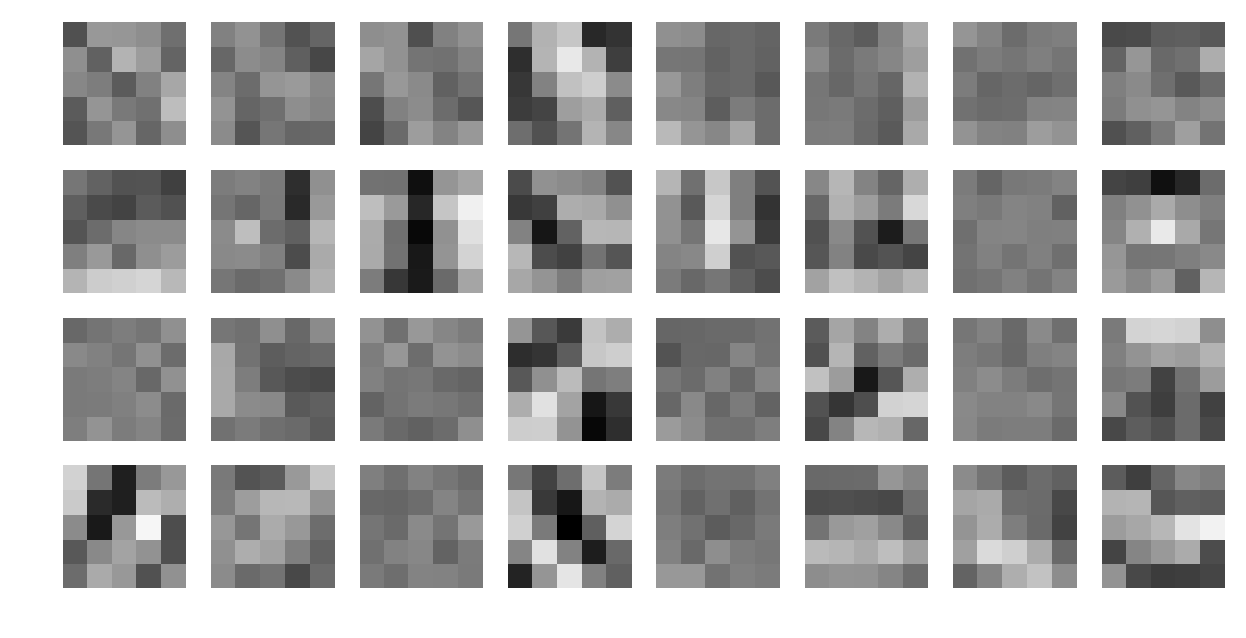

In [7]:
from itertools import product
from matplotlib import patches as patches

batchSize = 128
numberOfEpoch = 800
lr = 5e-3
result_dir = './results/res'+str(lr)+'+bs'+str(batchSize)+'+ep'+str(numberOfEpoch)

# --------------------------------------------------
# Initialize and restore model
tf.reset_default_graph()
model = LeNet5(tf.placeholder(tf.float32, [None, imsize, imsize, nchannels]), 
               tf.placeholder(tf.float32, [None, nclass]))
model.loss(learning_rate = lr)
model.restore(result_dir)
model.test(Test, LTest)

# --------------------------------------------------
# Retrieve weights from layer 1

W1 = model.get_filters("conv1/weights")

# --------------------------------------------------
# Display

vmax = np.abs(W1).max() # for better display
plt.figure(figsize=(10,5), dpi=150)
for i, j in product(range(4), range(8)):
    k = i*8 + j
    ax = plt.subplot(4, 8, k+1)
    plt.pcolormesh(np.flipud(W1[:, :, 0, k]), vmin=-vmax, vmax=vmax, cmap='gray')
    plt.axis('off')
plt.show()

<center> Figure 3 Weights visualization of the first convolutional layer </center>


### - Activations statistics
Also, show the statistics (min, max, mean, standard deviation, histogram) of the activations in the convolutional layers on test images. Figure 4 shows the hostograms. It can be observed that the feature maps are sparse. Feature maps following higher layers are even more sparse.

Added one method to the ```LeNet5``` class: ```LeNet5.get_activations(layer, data)``` returns activations of the given data and layer. ```vis_activations_hist()``` is a helper function that plots histograms. See more detail in ```trainCifarStarterCode.py```.

A_conv1: min = 0.000000, max = 2.988647, mean = 0.201487, standard deviation = 0.320498
A_conv2: min = 0.000000, max = 5.761255, mean = 0.164984, standard deviation = 0.336293
A_fc1: min = 0.000000, max = 7.578070, mean = 0.217543, standard deviation = 0.498959
A_fc2: min = 0.000000, max = 1.000000, mean = 0.100000, standard deviation = 0.237226


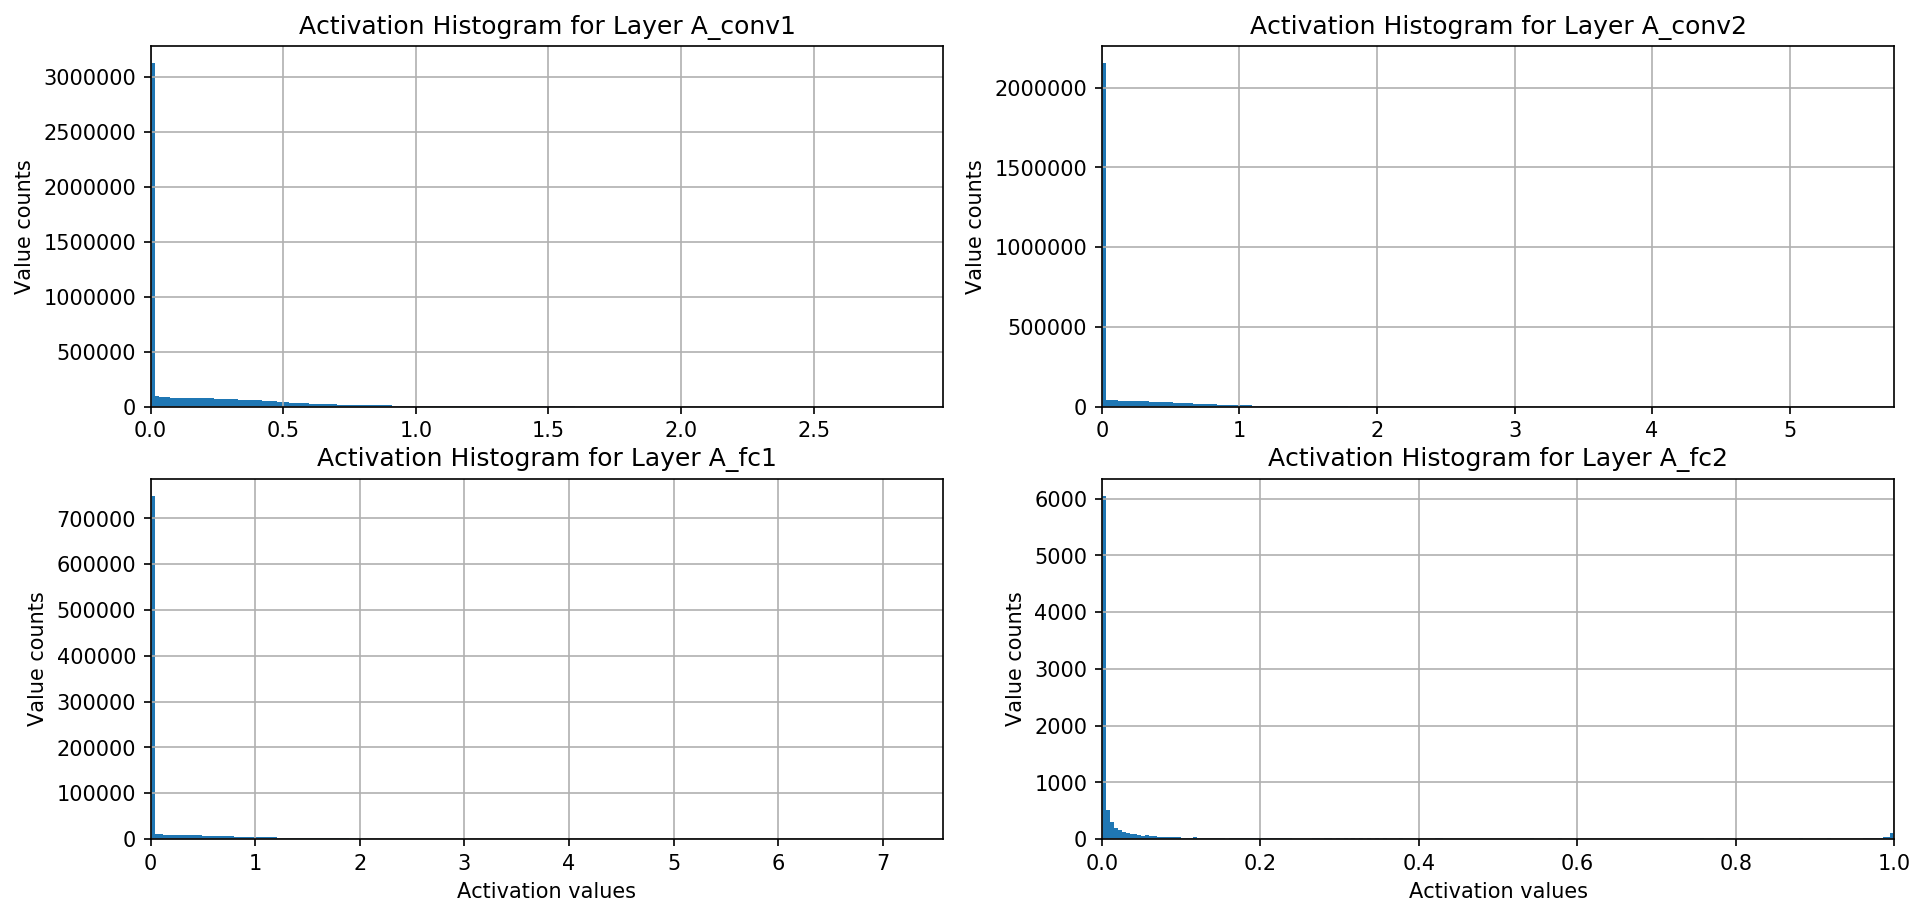

In [15]:
layers = {"A_conv1":model.h_pool1, "A_conv2":model.h_pool2, "A_fc1":model.h_fc1, "A_fc2":model.y_}
A = []

for name, layer in layers.items():
    A.append(model.get_activations(layer, Test))
    print("{:s}: min = {:.6f}, max = {:.6f}, mean = {:.6f}, standard deviation = {:.6f}".format(
        name, A[-1].min(),A[-1].max(),A[-1].mean(), A[-1].std()))
        
_, axes = plt.subplots(2,2, figsize=(15,7), dpi=150)
for i, (a, ax) in enumerate(zip(A, axes.flatten())):
    vis_activations_hist(a, ax, "Activation Histogram for Layer "+list(layers.keys())[i], xname=i>1)

<center>Figure 4 Activation histograms for feature maps after each convolutional and fully connected layers</center>

## 2 Visualizing and Understanding Convolutional Networks

### Summary of [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf):

- The authors designed a visualization technique based on deconvolutional networks. It helped people understand what each layer learns and provided insights for architecture selection. 
- Deconvolution networks are essentially same with Convnet, but in reverse. It first unpools feature maps and then convolves unpooled maps. It is an unsupervised method: the filters are copied from trained Convnet. Reusing feedforward switches was critical to preserving edge information and reconstructing interpretable projections. 
- To visualize higher layers, the authors took max activations from feature map, used specific pooling indices to deconvolve and project them back to pixel space. 
- The authors also demonstrated some visualizations on the ImageNet object recognition task. In terms of hidden layer interpretation, the first layer seemed to be capturing edge and color informations, and the second layer textures and curves. In general, higher layers contained more complex features and higher-level abstractions. 
- The authors pointed out that Deconvnet could also serve as a generative model to localize the strongest activations. 

*Ref: https://arxiv.org/pdf/1311.2901.pdf*

## 3 Build and Train an RNN on MNIST

For implementation detail please see ```lstmMNISTStarterCode.py```.

*Ref: TensorFlow examples at https://www.tensorflow.org*

In [5]:
import tensorflow as tf 
from tensorflow.contrib import rnn
import numpy as np 
from time import time

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)#call mnist function

learningRate = 5e-3
trainingIters = 50000
batchSize = 128
displayStep = 200

nInput = 28 #we want the input to take the 28 pixels
nSteps = 28 #every 28
nHidden = 128 #number of neurons for the RNN
nClasses = 10 #this is MNIST so you know

def RNN(x, weights, biases, family="rnn"):
    
    x = tf.unstack(x, nSteps, 1)
#     x = tf.transpose(x, [1,0,2])
#     x = tf.reshape(x, [-1, nInput])
#     x = tf.split(0, nSteps, x) #configuring so you can get it as needed for the 28 pixels

    #find which lstm to use in the documentation
    if family=="rnn":
        rnnCell = rnn.BasicRNNCell(nHidden)
    elif family=="lstm":
        rnnCell = rnn.BasicLSTMCell(nHidden, forget_bias=1.0)
    elif family=="gru":
        rnnCell = rnn.GRUCell(nHidden)
    else:
        raise NotImplemented

    outputs, states = rnn.static_rnn(rnnCell, x, dtype=tf.float32)#for the rnn where to get the output and hidden state 

    return tf.matmul(outputs[-1], weights['out'])+ biases['out']


"""
Integrating training, testing and summary processes
"""
def train_rnn(family = 'rnn'):
    tf.reset_default_graph()

    x = tf.placeholder('float', [None, nSteps, nInput])
    y = tf.placeholder('float', [None, nClasses])

    weights = {
        'out': tf.Variable(tf.random_normal([nHidden, nClasses]))
    }

    biases = {
        'out': tf.Variable(tf.random_normal([nClasses]))
    }

    pred = RNN(x, weights, biases, family)
    prediction = tf.nn.softmax(pred)

    rnn_result_dir = './results/rnn/'+family+'_res'+str(learningRate)+'+bs'+str(batchSize)+'+ep'+str(trainingIters)
    if not os.path.exists(rnn_result_dir): os.makedirs(rnn_result_dir)

    #optimization
    #create the cost, optimization, evaluation, and accuracy
    #for the cost softmax_cross_entropy_with_logits seems really good
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningRate).minimize(cost)
    correctPred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

    tf.summary.scalar("loss", cost)
    tf.summary.scalar("accuracy", accuracy)
    summary_op = tf.summary.merge_all()

    # load test data
    testData = mnist.test.images.reshape((-1, nSteps, nInput))
    testLabel = mnist.test.labels

    start_time = time()
    with tf.Session() as sess:

        # Run the initializer
        sess.run(tf.global_variables_initializer())

        train_writer = tf.summary.FileWriter(rnn_result_dir+'/train', sess.graph)
        test_writer = tf.summary.FileWriter(rnn_result_dir+'/test', sess.graph)

        # Save best model and tensorboard log files
        saver = tf.train.Saver()
        checkpoint_file = rnn_result_dir+'/checkpoint'

        best_acc = 0
        save = True
        for step in range(1, trainingIters+1):

            batchX, batchY = mnist.train.next_batch(batchSize)
            batchX = batchX.reshape((batchSize, nSteps, nInput))

            if step % displayStep != 0:

                sess.run(optimizer, feed_dict={x: batchX, y: batchY})

            else:
                # Calculate batch loss and accuracy
                train_summary_str, loss_train, acc_train = \
                    sess.run([summary_op, cost, accuracy], feed_dict={x: batchX, y: batchY}) # train
                test_summary_str, loss_test, acc_test = \
                    sess.run([summary_op, cost, accuracy], feed_dict={x: testData, y: testLabel}) # test

                # add to tensorboard summary
                train_writer.add_summary(train_summary_str, step)
                train_writer.flush()

                test_writer.add_summary(test_summary_str, step)
                test_writer.flush()

                print('''Step {}, Minibatch Loss= {:.6f}, Training Accuracy= {:.5f}, Test Loss= {:.6f}, Test Accuracy= {:.5f}'''\
                      .format(step, loss_train, acc_train, loss_test, acc_test))

                # keep tracking best accuracy
                if acc_test > best_acc:
                    best_acc = acc_test
                    if save:
                        saver.save(sess, checkpoint_file, global_step=step)
                        print("Saving...")

        print('Optimization finished')
        end_time = time()

        print("Runtime: {:.2f} s".format(end_time - start_time),
              ", Testing Accuracy:", sess.run(accuracy, feed_dict={x: testData, y: testLabel}))



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### a) Setup an RNN

Uses basic RNN (https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/BasicRNNCell). 

In [2]:
train_rnn('rnn')

Step 200, Minibatch Loss= 1.167622, Training Accuracy= 0.63281, Test Loss= 1.110695, Test Accuracy= 0.60910
Saving...
Step 400, Minibatch Loss= 0.790002, Training Accuracy= 0.73438, Test Loss= 0.832370, Test Accuracy= 0.71800
Saving...
Step 600, Minibatch Loss= 0.585200, Training Accuracy= 0.81250, Test Loss= 0.692402, Test Accuracy= 0.77840
Saving...
Step 800, Minibatch Loss= 0.768205, Training Accuracy= 0.78906, Test Loss= 0.599267, Test Accuracy= 0.81300
Saving...
Step 1000, Minibatch Loss= 0.338146, Training Accuracy= 0.91406, Test Loss= 0.535571, Test Accuracy= 0.83290
Saving...
Step 1200, Minibatch Loss= 0.452490, Training Accuracy= 0.88281, Test Loss= 0.493861, Test Accuracy= 0.84640
Saving...
Step 1400, Minibatch Loss= 0.551312, Training Accuracy= 0.85156, Test Loss= 0.453329, Test Accuracy= 0.86270
Saving...
Step 1600, Minibatch Loss= 0.392993, Training Accuracy= 0.88281, Test Loss= 0.425465, Test Accuracy= 0.87030
Saving...
Step 1800, Minibatch Loss= 0.438590, Training Accura

Step 14600, Minibatch Loss= 0.075717, Training Accuracy= 0.97656, Test Loss= 0.142095, Test Accuracy= 0.95830
Saving...
Step 14800, Minibatch Loss= 0.090738, Training Accuracy= 0.96875, Test Loss= 0.139307, Test Accuracy= 0.95750
Step 15000, Minibatch Loss= 0.073318, Training Accuracy= 0.96094, Test Loss= 0.135667, Test Accuracy= 0.95780
Step 15200, Minibatch Loss= 0.190798, Training Accuracy= 0.95312, Test Loss= 0.146801, Test Accuracy= 0.95540
Step 15400, Minibatch Loss= 0.152481, Training Accuracy= 0.96094, Test Loss= 0.140410, Test Accuracy= 0.95820
Step 15600, Minibatch Loss= 0.154124, Training Accuracy= 0.96094, Test Loss= 0.136705, Test Accuracy= 0.95790
Step 15800, Minibatch Loss= 0.128239, Training Accuracy= 0.97656, Test Loss= 0.137604, Test Accuracy= 0.95760
Step 16000, Minibatch Loss= 0.112254, Training Accuracy= 0.97656, Test Loss= 0.135645, Test Accuracy= 0.96050
Saving...
Step 16200, Minibatch Loss= 0.134659, Training Accuracy= 0.95312, Test Loss= 0.138443, Test Accuracy

### b) How about using an LSTM or GRU
Plot the train/test accuracies and the train loss. What do you notice and are the LSTM or GRU better? Also, change the number of hidden units and see how that affects the loss and accuracy.

In [3]:
train_rnn('lstm')

Step 200, Minibatch Loss= 2.203784, Training Accuracy= 0.27344, Test Loss= 2.153664, Test Accuracy= 0.27690
Saving...
Step 400, Minibatch Loss= 1.951020, Training Accuracy= 0.32812, Test Loss= 1.963062, Test Accuracy= 0.33850
Saving...
Step 600, Minibatch Loss= 1.929882, Training Accuracy= 0.34375, Test Loss= 1.817904, Test Accuracy= 0.38560
Saving...
Step 800, Minibatch Loss= 1.697181, Training Accuracy= 0.51562, Test Loss= 1.704367, Test Accuracy= 0.44360
Saving...
Step 1000, Minibatch Loss= 1.578654, Training Accuracy= 0.53125, Test Loss= 1.614110, Test Accuracy= 0.47340
Saving...
Step 1200, Minibatch Loss= 1.470491, Training Accuracy= 0.53125, Test Loss= 1.532996, Test Accuracy= 0.51310
Saving...
Step 1400, Minibatch Loss= 1.588920, Training Accuracy= 0.45312, Test Loss= 1.460251, Test Accuracy= 0.53820
Saving...
Step 1600, Minibatch Loss= 1.472628, Training Accuracy= 0.54688, Test Loss= 1.393337, Test Accuracy= 0.55880
Saving...
Step 1800, Minibatch Loss= 1.491206, Training Accura

Step 14000, Minibatch Loss= 0.216558, Training Accuracy= 0.92969, Test Loss= 0.288588, Test Accuracy= 0.90850
Saving...
Step 14200, Minibatch Loss= 0.302504, Training Accuracy= 0.89844, Test Loss= 0.285006, Test Accuracy= 0.90830
Step 14400, Minibatch Loss= 0.361427, Training Accuracy= 0.91406, Test Loss= 0.280253, Test Accuracy= 0.91060
Saving...
Step 14600, Minibatch Loss= 0.295507, Training Accuracy= 0.92188, Test Loss= 0.275207, Test Accuracy= 0.91250
Saving...
Step 14800, Minibatch Loss= 0.228727, Training Accuracy= 0.89844, Test Loss= 0.273785, Test Accuracy= 0.91210
Step 15000, Minibatch Loss= 0.226142, Training Accuracy= 0.93750, Test Loss= 0.271624, Test Accuracy= 0.91230
Step 15200, Minibatch Loss= 0.196589, Training Accuracy= 0.93750, Test Loss= 0.262590, Test Accuracy= 0.91690
Saving...
Step 15400, Minibatch Loss= 0.214113, Training Accuracy= 0.91406, Test Loss= 0.258860, Test Accuracy= 0.91800
Saving...
Step 15600, Minibatch Loss= 0.217757, Training Accuracy= 0.94531, Test

In [4]:
train_rnn('gru')

Step 200, Minibatch Loss= 2.050346, Training Accuracy= 0.30469, Test Loss= 1.867151, Test Accuracy= 0.37290
Saving...
Step 400, Minibatch Loss= 1.694068, Training Accuracy= 0.41406, Test Loss= 1.676015, Test Accuracy= 0.46590
Saving...
Step 600, Minibatch Loss= 1.559627, Training Accuracy= 0.50781, Test Loss= 1.543643, Test Accuracy= 0.51700
Saving...
Step 800, Minibatch Loss= 1.405779, Training Accuracy= 0.57031, Test Loss= 1.437613, Test Accuracy= 0.55180
Saving...
Step 1000, Minibatch Loss= 1.433548, Training Accuracy= 0.56250, Test Loss= 1.352825, Test Accuracy= 0.57880
Saving...
Step 1200, Minibatch Loss= 1.381450, Training Accuracy= 0.51562, Test Loss= 1.284737, Test Accuracy= 0.60200
Saving...
Step 1400, Minibatch Loss= 1.232100, Training Accuracy= 0.63281, Test Loss= 1.231158, Test Accuracy= 0.61680
Saving...
Step 1600, Minibatch Loss= 1.277324, Training Accuracy= 0.57812, Test Loss= 1.183004, Test Accuracy= 0.63040
Saving...
Step 1800, Minibatch Loss= 1.302469, Training Accura

Saving...
Step 14200, Minibatch Loss= 0.379901, Training Accuracy= 0.89062, Test Loss= 0.331282, Test Accuracy= 0.90090
Saving...
Step 14400, Minibatch Loss= 0.201551, Training Accuracy= 0.93750, Test Loss= 0.326769, Test Accuracy= 0.90080
Step 14600, Minibatch Loss= 0.373201, Training Accuracy= 0.90625, Test Loss= 0.322316, Test Accuracy= 0.90170
Saving...
Step 14800, Minibatch Loss= 0.426250, Training Accuracy= 0.84375, Test Loss= 0.316317, Test Accuracy= 0.90620
Saving...
Step 15000, Minibatch Loss= 0.282537, Training Accuracy= 0.90625, Test Loss= 0.311972, Test Accuracy= 0.90450
Step 15200, Minibatch Loss= 0.233950, Training Accuracy= 0.94531, Test Loss= 0.307302, Test Accuracy= 0.90750
Saving...
Step 15400, Minibatch Loss= 0.306458, Training Accuracy= 0.89062, Test Loss= 0.303910, Test Accuracy= 0.90870
Saving...
Step 15600, Minibatch Loss= 0.434400, Training Accuracy= 0.86719, Test Loss= 0.299382, Test Accuracy= 0.91060
Saving...
Step 15800, Minibatch Loss= 0.267507, Training Acc

For the MNIST classification task, LSTM (93.7%) and GRU (93.3%) seem to have similar test accuracy (LSTM = 93.7%, GRU = 93.3%). To train same number of epochs (20,000) on a GeForce GTX 1080 Ti, GRU (297.77 s) took slightly more time than LSTM (267.77 s). That said, Both of them were significantly slower to train than the basic RNN (126.94 s), and both slightly below the test accuracy of the basic RNN (96.2%). 

From the training logs shown in Figure 5, it seemed that more epochs would be very likely to further boost the accuracies, because the losses were still in a decreasing trend. With more epochs, GRU and LSTM might be able to converge to or even outperform the curves of RNN, but we did not look into that particularly due to their time-consuming characteristics. 

One hypothesis to this is that the data structure was fairly simple - there were no very long-term interactions and all sequences had the same length, thus the network did not need to utilize the advantages of gated cells but still suffered from their complexity. 

<img src="https://github.com/bl166/LearningDeepLearning/blob/master/figures/Picture3.png?raw=true">


<center>Figure 5 Training and test accuracy and loss vs epoch</center>

### c) Compare against the CNN

The recurrent networks achieved remarkably good performance (test accuracy = 96.7%), very competative to what my best performing convolutional networks in Assignment\#1 (test accuracy = 96%). Nonetheless, state-of-the-art Convnets are able to reach over 99% test accuracy with tweaks on the model architecture and training methods. The reason of RNN's good performance could be due to the local pixel continuity in the images of digit. Even though, convolutional nueral networks are more natural and intuitive for image tasks. With visualization technique from part b), people are able to gain knowledge on the mechanics of its training and inference behaviors. Therefore, despite of the reasonably good performance of RNN, I think CNN will still be dominating image-based tasks. 

